In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch

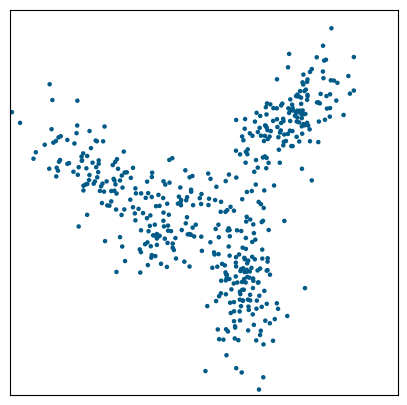

In [120]:
means_data = torch.tensor([[0.5,0], [3,2], [-1,1],[2,-1]])*2
covs_data = torch.tensor([[[1,0],[0,1]], [[1,0.5],[0.5,1]], [[1,-0.5],[-0.5,1]], [[0.5,0],[0,4]]])
covs_data[1] *= 1
weights_data = torch.tensor([0.2, 0.3, 0.2,0.3])

def gmm_sample(means, covs, weights, n):
    data = torch.zeros((len(means), n, 2))
    for i in range(len(means)):
        data[i] = torch.from_numpy(np.random.multivariate_normal(means[i].numpy(), covs[i].numpy(), n))
    indices = torch.multinomial(weights, n, replacement=True)
    return data[indices, np.arange(n), :]

yblue = (0.,90/255,135/255)
chestnut = (0.8,0.7,0.5)
data = gmm_sample(means_data, covs_data, weights_data, 500)
plt.figure(figsize=(5,5))
plt.xlim(-5,10)
plt.ylim(-7,8)
plt.xticks([]); plt.yticks([])
plt.scatter(data[:,0], data[:,1], c=[yblue]*len(data), s=5)
plt.savefig('gmm-approx/gmm_data.pdf', bbox_inches='tight')

torch.Size([22500, 2])


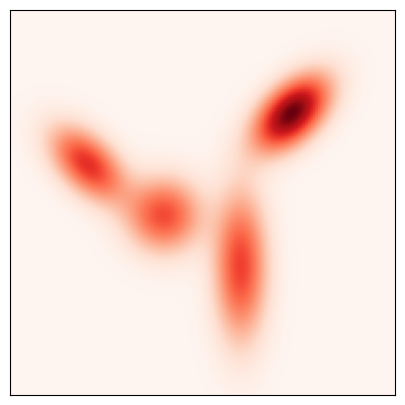

In [124]:
def gmm_density(X, means=means_data, covs=covs_data, weights=weights_data):
    density = torch.zeros(X.shape[0])
    for i in range(len(means)):
        density += weights[i]*torch.exp(-0.5*torch.sum((X-means[i])@torch.linalg.inv(covs[i])*(X-means[i]), axis=1))/torch.sqrt((2*np.pi)**2*torch.det(covs[i]))
    return density

X = np.mgrid[-5:10:0.1, -7:8:0.1].reshape(2,-1).T
XX,YY = torch.meshgrid(torch.linspace(-5,10,150), torch.linspace(-7,8,150))
X = torch.stack([XX.reshape(-1), YY.reshape(-1)], dim=1)
print(X.shape)
density = gmm_density(X).reshape(150,150).T
plt.figure(figsize=(5,5))
plt.xlim(-5,10)
plt.ylim(-7,8)
plt.xticks([]); plt.yticks([])
plt.imshow((density), extent=(-5,10,-7,8), origin='lower', cmap='Reds')
# plt.contour(density, levels=np.linspace(density.min(),density.max(),4), extent=(-5,10,-7,8), colors='black', linewidths=1, alpha=0.25)
# plt.contour(density, levels=np.linspace(density.min(),density.max(),10), extent=(-5,10,-7,8), colors='black', linewidths=0.25, alpha=0.25)
plt.savefig('gmm-approx/gmm_density.pdf', bbox_inches='tight')
plt.show()

In [122]:
def estimate_kl(means_p, covs_p, weights_p, means_q, covs_q, weights_q, n_samples=1000):
    with torch.no_grad():
        samples = gmm_sample(means_p, covs_p, weights_p, n_samples)
        p_density = gmm_density(samples, means_p, covs_p, weights_p)
        q_density = gmm_density(samples, means_q, covs_q, weights_q)
        kl = torch.mean(torch.log(p_density) - torch.log(q_density))
    return kl.item()
def estimate_metrics(means_p, covs_p, weights_p, means_q, covs_q, weights_q, n_samples=1000):
    with torch.no_grad():
        samples_p = gmm_sample(means_p, covs_p, weights_p, n_samples)
        p_density_p = gmm_density(samples_p, means_p, covs_p, weights_p)
        q_density_p = gmm_density(samples_p, means_q, covs_q, weights_q)
        fwd_kl = torch.mean(torch.log(p_density_p) - torch.log(q_density_p))
        
        samples_q = gmm_sample(means_q, covs_q, weights_q, n_samples)
        p_density_q = gmm_density(samples_q, means_p, covs_p, weights_p)
        q_density_q = gmm_density(samples_q, means_q, covs_q, weights_q)
        rev_kl = torch.mean(torch.log(q_density_q) - torch.log(p_density_q))
        
        m_density_p = 0.5 * (p_density_p + q_density_p)
        m_density_q = 0.5 * (p_density_q + q_density_q)
        jsd = 0.5 * (torch.mean(torch.log(p_density_p) - torch.log(m_density_p)) + torch.mean(torch.log(q_density_q) - torch.log(m_density_q)))
    return fwd_kl.abs().item(), rev_kl.abs().item(), jsd.abs().item()

Objective: fkl, n_comps_model: 1


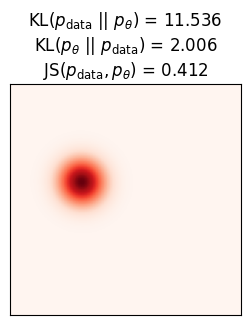

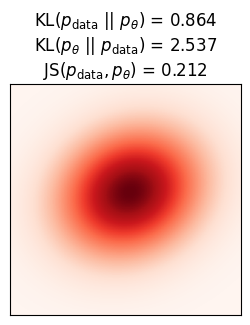

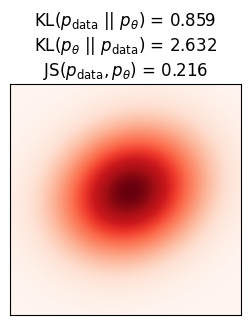

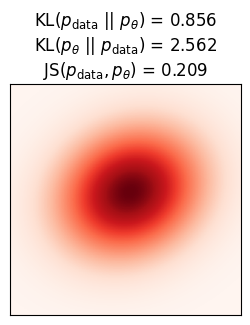

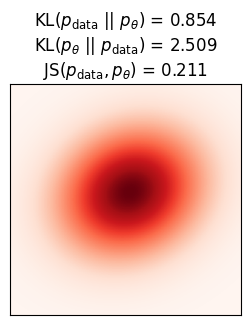

Objective: fkl, n_comps_model: 2


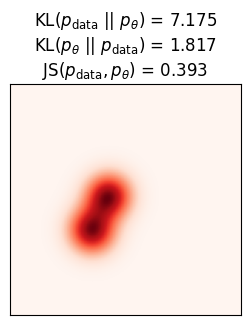

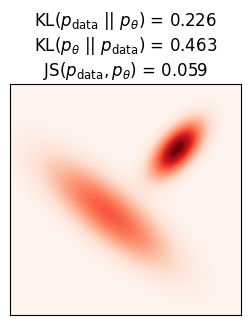

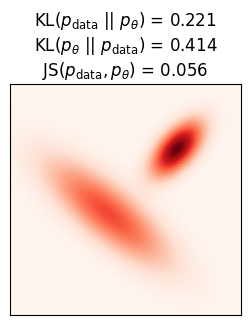

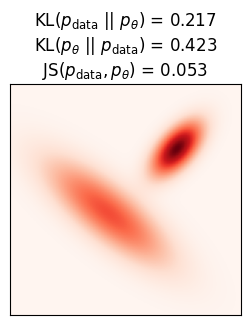

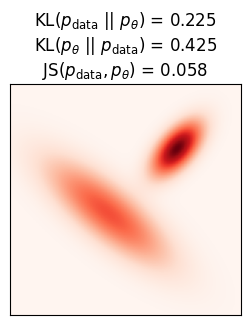

Objective: fkl, n_comps_model: 3


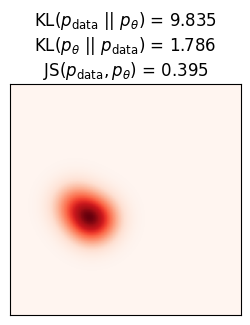

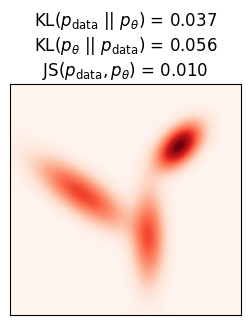

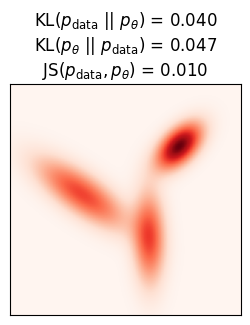

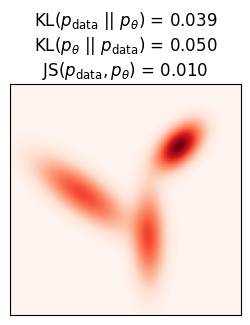

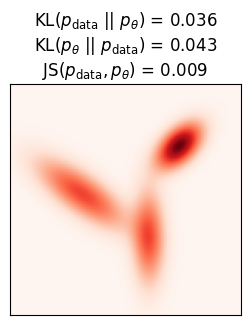

Objective: fkl, n_comps_model: 4


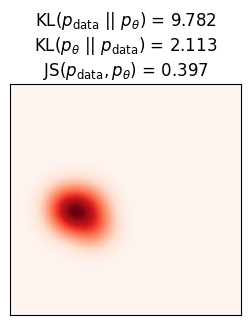

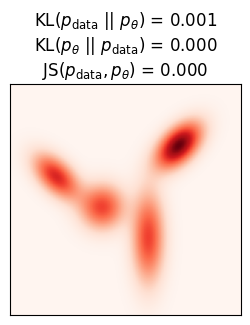

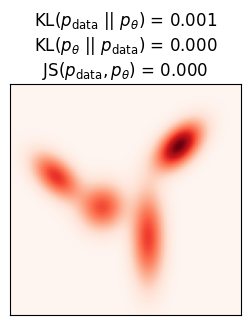

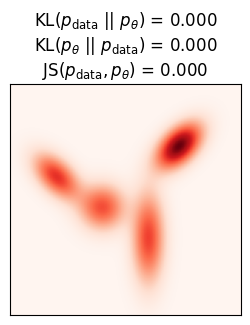

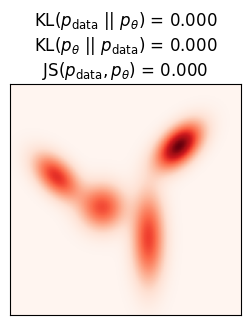

Objective: rkl, n_comps_model: 1


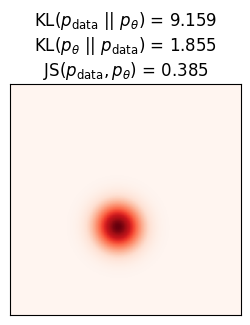

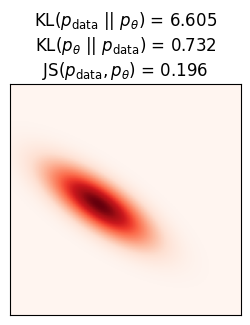

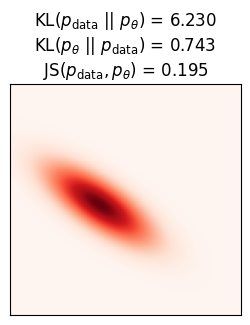

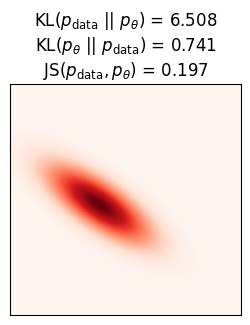

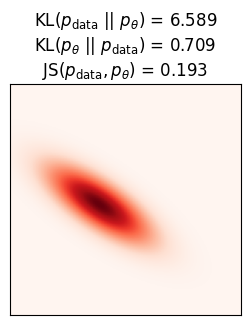

Objective: rkl, n_comps_model: 2


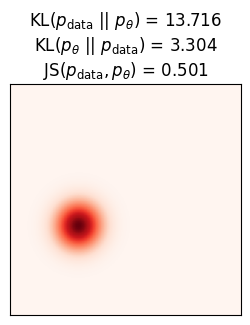

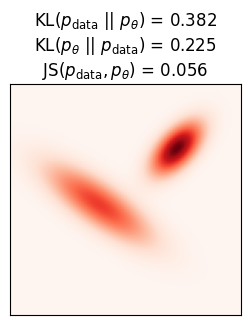

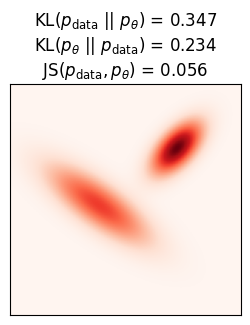

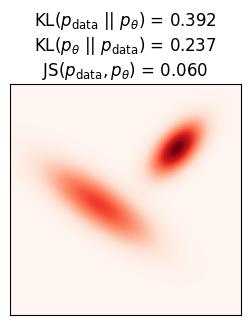

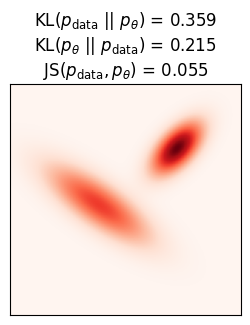

Objective: rkl, n_comps_model: 3


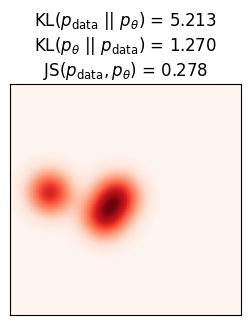

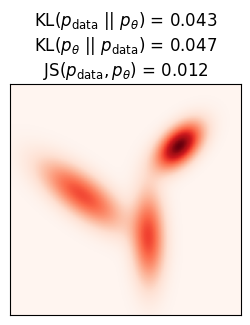

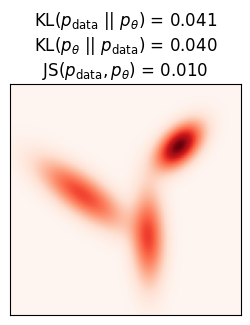

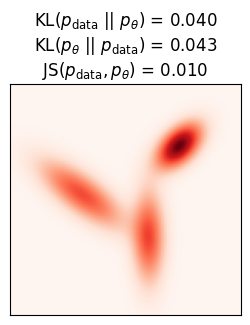

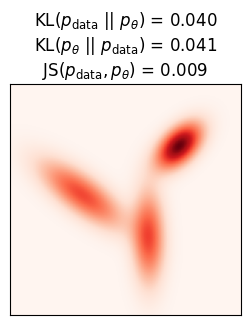

Objective: rkl, n_comps_model: 4


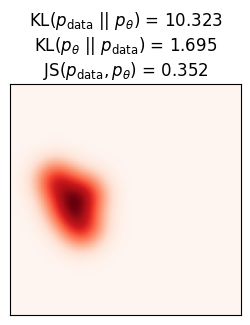

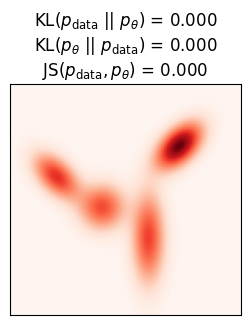

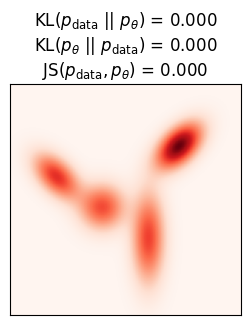

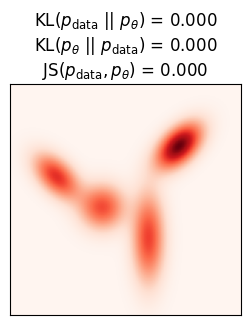

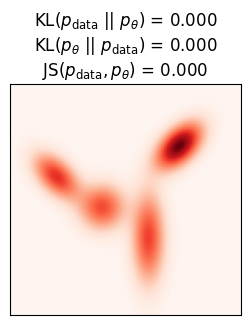

Objective: jsd, n_comps_model: 1


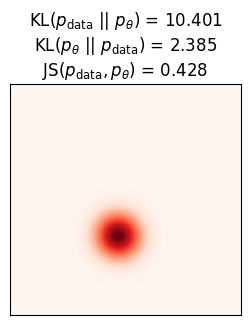

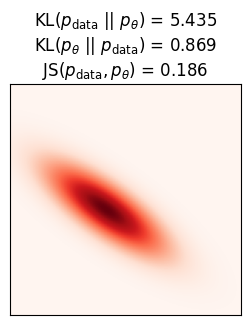

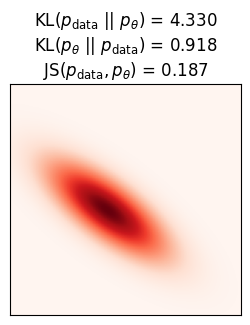

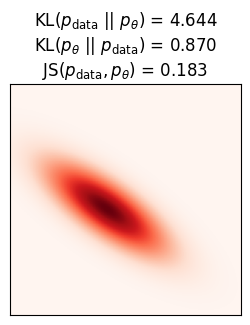

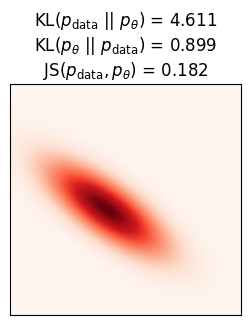

Objective: jsd, n_comps_model: 2


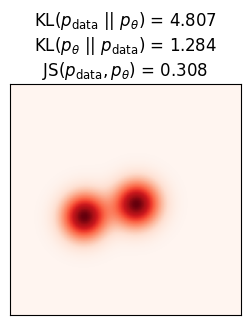

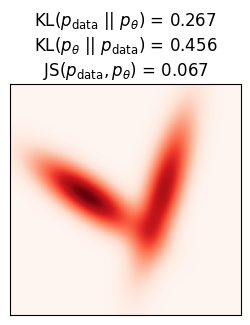

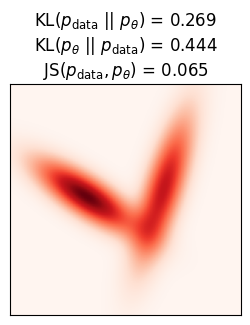

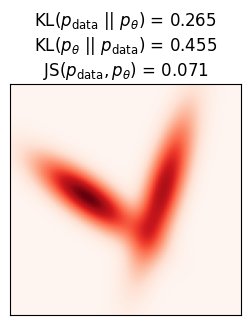

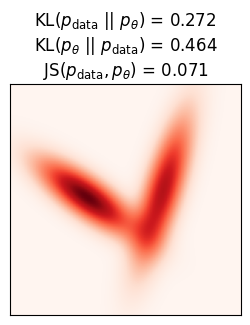

Objective: jsd, n_comps_model: 3


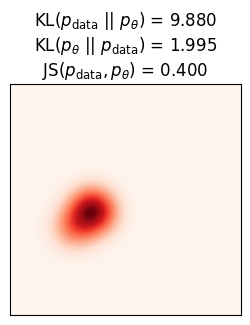

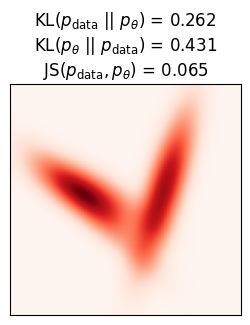

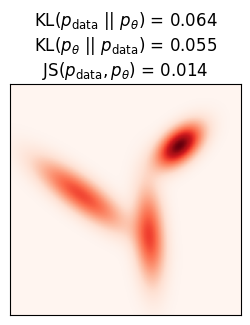

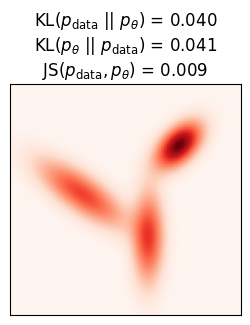

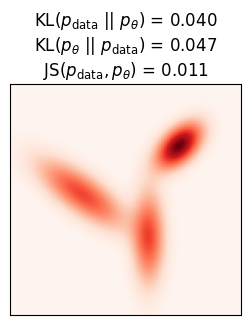

Objective: jsd, n_comps_model: 4


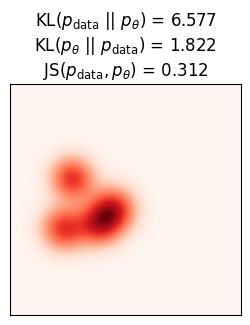

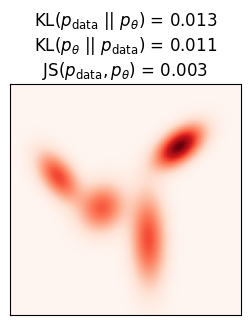

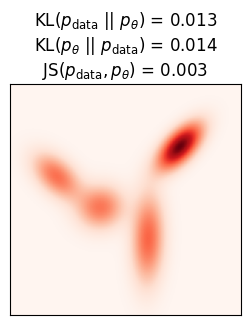

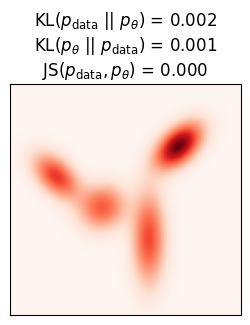

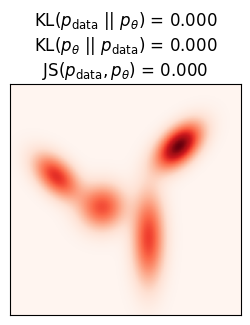

In [123]:
def fit_model(objective, n_comps_model=4):
    means_model = torch.randn((n_comps_model, 2))
    sqcovs_model = torch.stack([torch.eye(2) for _ in range(n_comps_model)])
    weights_model = torch.zeros(n_comps_model)

    means_model.requires_grad_(True)
    sqcovs_model.requires_grad_(True)
    weights_model.requires_grad_(True)

    opt = torch.optim.Adam([means_model, sqcovs_model, weights_model], lr=0.01)

    batch_size = 1024
    for it in range(20001):
        if it == 10000:
            for g in opt.param_groups:
                g['lr'] = 0.001
        if it == 15000:
            for g in opt.param_groups:
                g['lr'] = 0.0001

        if objective == 'fkl':
            data = gmm_sample(means_data, covs_data, weights_data, batch_size)
            density_data = gmm_density(data)
            density_model = gmm_density(data, means_model, sqcovs_model@sqcovs_model.transpose(-1,-2), torch.softmax(weights_model, dim=0))
            loss = -torch.mean(torch.log(density_model) - torch.log(density_data))
        elif objective == 'rkl':
            with torch.no_grad():
                data = gmm_sample(means_model, sqcovs_model@sqcovs_model.transpose(-1,-2), torch.softmax(weights_model, dim=0), batch_size)
            density_data = gmm_density(data)
            density_model = gmm_density(data, means_model, sqcovs_model@sqcovs_model.transpose(-1,-2), torch.softmax(weights_model, dim=0))
            # loss = torch.var(torch.log(density_model) - torch.log(density_data))
            loss = (torch.log(density_model) * (torch.log(density_model) - torch.log(density_data)).detach()).mean()
        elif objective == 'jsd':
            with torch.no_grad():
                data_model = gmm_sample(means_model, sqcovs_model@sqcovs_model.transpose(-1,-2), torch.softmax(weights_model, dim=0), batch_size).detach()
                data_data = gmm_sample(means_data, covs_data, weights_data, batch_size)
                data_comb = torch.cat([data_model, data_data], dim=0)
            density_data = gmm_density(data_comb)
            density_model = gmm_density(data_comb, means_model, sqcovs_model@sqcovs_model.transpose(-1,-2), torch.softmax(weights_model, dim=0))
            density_middle = (density_data + density_model) / 2
            loss = density_middle.log().pow(2).mean() - 0.5 * density_model[:batch_size].log().pow(2).mean()
            loss = -loss * 10
        opt.zero_grad()
        loss.backward()
        opt.step()
        if it % 5000 == 0:
            fkl, rkl, jsd = estimate_metrics(means_data, covs_data, weights_data, means_model, sqcovs_model@sqcovs_model.transpose(-1,-2), torch.softmax(weights_model, dim=0), n_samples=10000)
            # print(f"  Fwd KL: {fkl:.4f}, Rev KL: {rkl:.4f}, JSD: {jsd:.4f}")
            with torch.no_grad():
                density = gmm_density(X, means_model, sqcovs_model@sqcovs_model.transpose(-1,-2), torch.softmax(weights_model, dim=0)).reshape(150,150).T
                plt.figure(figsize=(3,3))
                plt.xlim(-5,10)
                plt.ylim(-7,8)
                plt.xticks([]); plt.yticks([])
                plt.imshow((density), extent=(-5,10,-7,8), origin='lower', cmap='Reds')
                s = f"KL($p_{{\\text{{data}}}}\ ||\ p_\\theta$) = {fkl:.3f}\n"
                s += f"KL($p_\\theta\ ||\ p_{{\\text{{data}}}}$) = {rkl:.3f}\n"
                s += f"JS($p_{{\\text{{data}}}},p_\\theta$) = {jsd:.3f}"
                plt.title(s)

                if it==20000:
                    plt.savefig(f'gmm-approx/gmm_fit_{objective}_ncomps{n_comps_model}.pdf', bbox_inches='tight')

                plt.show()

for objective in ['fkl', 'rkl', 'jsd']:
    for n_comps_model in [1,2,3,4]:
        print(f"Objective: {objective}, n_comps_model: {n_comps_model}")
        fit_model(objective, n_comps_model=n_comps_model)


In [118]:
plt

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/pyplot.py'>

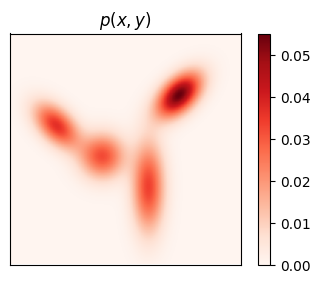

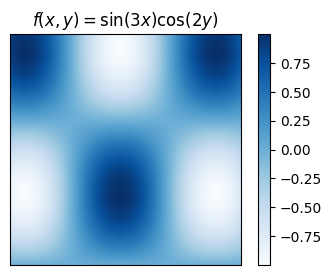

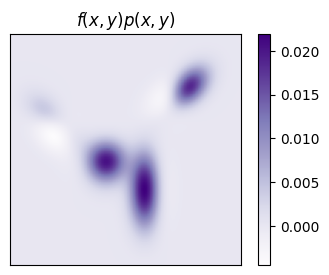

tensor(0.2952)


In [190]:
def thefn(x):
    return torch.sin(x[:,0]/2+0.5)*torch.cos(x[:,1]/3+0.8)

# X = np.mgrid[-5:10:0.1, -7:8:0.1].reshape(2,-1).T
XX,YY = torch.meshgrid(torch.linspace(-5,10,150), torch.linspace(-7,8,150))
X = torch.stack([XX.reshape(-1), YY.reshape(-1)], dim=1)

density = gmm_density(X).reshape(150,150).T

thefn_values = thefn(X).reshape(150,150).T


plt.figure(figsize=(4.5,3))
plt.xlim(-5,10)
plt.ylim(-7,8)
plt.xticks([]); plt.yticks([])
plt.imshow((density), extent=(-5,10,-7,8), origin='lower', cmap='Reds')
plt.colorbar()
plt.title("$p(x,y)$")
plt.savefig('gmm-approx/gmm_density_cb.pdf', bbox_inches='tight')

plt.show()

plt.figure(figsize=(4.5,3))
plt.xlim(-5,10)
plt.ylim(-7,8)
plt.xticks([]); plt.yticks([])
plt.imshow((thefn_values), extent=(-5,10,-7,8), origin='lower', cmap='Blues')
plt.colorbar()
plt.title("$f(x,y)=\sin(3x)\cos(2y)$")
plt.savefig('gmm-approx/gmm_fn_cb.pdf', bbox_inches='tight')

plt.show()

plt.figure(figsize=(4.5,3))
plt.xlim(-5,10)
plt.ylim(-7,8)
plt.xticks([]); plt.yticks([])
plt.imshow((thefn_values*density), extent=(-5,10,-7,8), origin='lower', cmap='Purples')
plt.colorbar()
plt.title("$f(x,y)p(x,y)$")
plt.savefig('gmm-approx/gmm_density_fn_cb.pdf', bbox_inches='tight')

plt.show()


print((thefn_values*density).sum() / 100)

0.2998223304748535
0.2994709312915802
0.2992516756057739
0.2978716492652893
0.29877158999443054
0.2992890775203705
0.2989684045314789
0.30000731348991394
0.2988848388195038
0.298105388879776


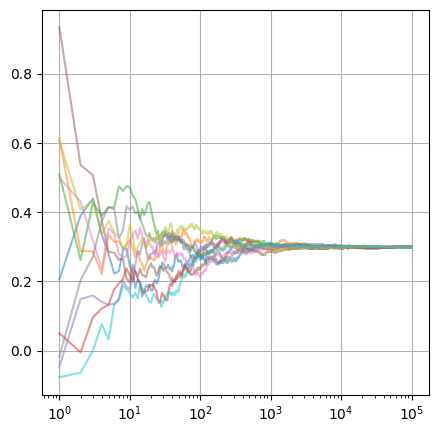

In [175]:
plt.figure(figsize=(5,5))
M = 100000
for _ in range(10):
    samples = gmm_sample(means_data, covs_data, weights_data, M)
    fn_values = thefn(samples)
    estimates = fn_values.cumsum(0) / torch.arange(1,M+1)
    plt.plot(torch.arange(1,M+1), estimates, alpha=0.5)
    print(estimates[-1].item())

plt.xscale('log')
plt.grid()

plt.savefig('gmm-approx/exp_convergence.png', bbox_inches='tight')

tensor(0.2993)

In [178]:
nums = """0.2998223304748535
0.2994709312915802
0.2992516756057739
0.2978716492652893
0.29877158999443054
0.2992890775203705
0.2989684045314789
0.30000731348991394
0.2988848388195038
0.298105388879776""".split('\n')

estimates = [float(x) for x in nums]
np.mean(estimates), np.std(estimates)

(0.2990443199872971, 0.0006465202168168528)

Integral over rectangle: 0.27747834
Integral over rectangle: 0.01407375
Integral over rectangle: 0.07295090
Integral over rectangle: 0.08489769
Integral over rectangle: 0.99357599


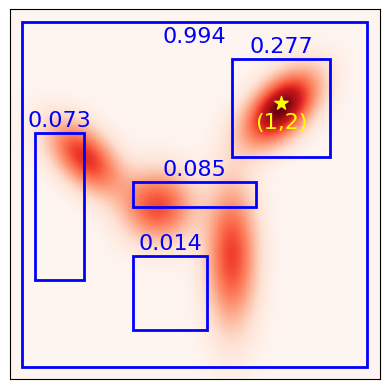

In [267]:
plt.xlim(-5,10)
plt.ylim(-7,8)
plt.xticks([]); plt.yticks([])
plt.imshow((density), extent=(-5,10,-7,8), origin='lower', cmap='Reds')



def rect(e1,e2,s1,s2,va='bottom'):
    XX,YY = torch.meshgrid(torch.linspace(e1,e1+s1,s1*100), torch.linspace(e2,e2+s2,s2*100))
    X = torch.stack([XX.reshape(-1), YY.reshape(-1)], dim=1)
    density_sub = gmm_density(X).reshape(s1*100,s2*100)
    integral = density_sub.sum() / (100*100)
    print(f"Integral over rectangle: {integral.item():.8f}")
    plt.gca().add_patch(plt.Rectangle((e1, e2), s1, s2, fill=False, edgecolor='blue', linewidth=2))
    plt.text(e1+s1/2, e2+s2-(0.2 if va=='top' else -0.1), f'{integral.item():.3f}', color='blue', fontsize=16, ha='center', va=va)

rect(4,2,4,4)
rect(0,-5,3,3)
rect(-4,-3,2,6)
rect(0,0,5,1)
rect(-4.5,-6.5,14,14,'top')

# put a big yellow star at one point
plt.scatter([6],[4.2],c='yellow',marker='*',s=100)
plt.text(6,3.8,'(1,2)',color='yellow',fontsize=16,ha='center',va='top')

plt.savefig('gmm-approx/gmm_density_rects.pdf', bbox_inches='tight')